In [184]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing Initial Combined Data

In [185]:
# This file integrates data from ADNIMERGE, MEDHIST, GDSCALE, MODHACH and uses the last available diagnosis of the 
# subject
# Does not standardize continuous predictors as non-linear models such as Random Forest/AdaBoost
import project_utils_v2

# Extracting training and set sets


In [186]:
X_train, y_train, X_test, y_test = project_utils_v2.get_data()
print("Number of predictors = ",X_train.shape[1])
print("Number of total subjects = ",X_train.shape[0]+X_test.shape[0])

Number of predictors =  55
Number of total subjects =  629


## For comparison using the data from adnimerge only

In [187]:
adnimerge = ['ADAS13_bl', 'RAVLT_immediate_bl', 'ICV_bl', 'AGE', 'WholeBrain_bl', 'Entorhinal_bl', 'RAVLT_learning_bl',
             'Hippocampus_bl', 'ADAS11_bl', 'RAVLT_perc_forgetting_bl', 'CDRSB_bl', 'MidTemp_bl', 'Fusiform_bl',
             'RAVLT_forgetting_bl', 'PTEDUCAT', 'MMSE_bl', 'Ventricles_bl', 'FAQ_bl', 'APOE4_1.0', 'APOE4_2.0', 
             'PTGENDER_Male', 'PTMARRY_Married','PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed',
             'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White']
X_train_adnimerge = X_train[adnimerge]
X_test_adnimerge = X_test[adnimerge]


## Comparing adnimerge data only with adnimerge+additional - logistic Regression

In [188]:
cvals = [1e-20, 1e-15, 1e-10, 1e-5, 1e-3, 1e-1, 1, 10, 100, 10000, 100000]
logregcv = LogisticRegressionCV(Cs=cvals,cv=5)
logregcv.fit(X_train, y_train)
logregcv_adnimerge = LogisticRegressionCV(Cs=cvals,cv=5)
logregcv_adnimerge.fit(X_train_adnimerge, y_train)


LogisticRegressionCV(Cs=[1e-20, 1e-15, 1e-10, 1e-05, 0.001, 0.1, 1, 10, 100, 10000, 100000],
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

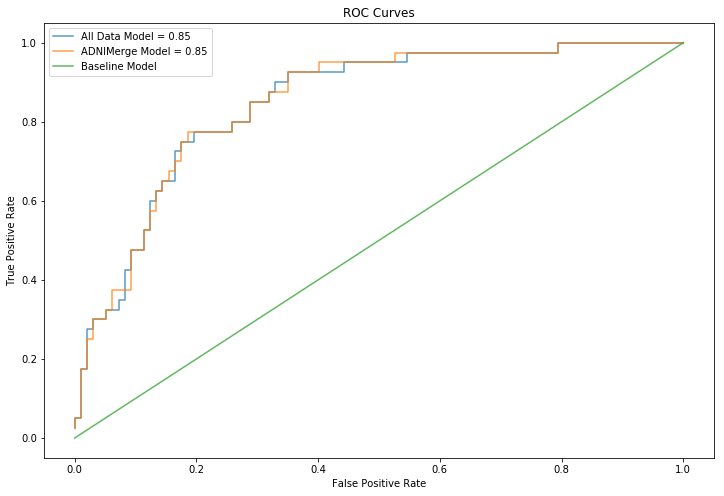

In [190]:

fpr, tpr, thresholds = metrics.roc_curve(y_test, logregcv.predict_proba(X_test)[:,1])
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, logregcv_adnimerge.predict_proba(X_test_adnimerge)[:,1])

roc_auc = auc(fpr, tpr)
auc_adnimerge = auc(fpr1, tpr1)

# We're using an array of 0's as our predicted probabilites, since we never
# choose 1. Thus, everything has a 0 probability of being a 1. 
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, np.zeros(y_test.shape[0]))

# Plot the ROC curve for the two models
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig.suptitle("")
alpha = 0.75
ax.plot(fpr, tpr, alpha=alpha, label='All Data Model = %0.2f'% roc_auc)
ax.plot(fpr1, tpr1, alpha=alpha, label='ADNIMerge Model = %0.2f'% auc_adnimerge)
ax.plot(fpr0, tpr0, alpha=alpha, label='Baseline Model')

ax.legend(loc='best');
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves');

We see that the adnimerge data and combined data (adnimerge+medhist+gdscale+modach), the performance is pretty much the same.
Running a lasso to eliminate muticollinearity to extract relevant predictos

## Removing Multi-collinearity

In [191]:
#Lasso with CV
lam = [0.,10e-5,10e-4,10e-3,10e-2,10e-1,1,10,10e2,10e3,10e4,10e5]
r_lasso = LassoCV(alphas=lam,fit_intercept=True,cv=5).fit(X_train, y_train)
x = np.append(r_lasso.intercept_.tolist(),r_lasso.coef_.tolist())
x = pd.DataFrame({'var':X_train.columns.tolist(),'coef':r_lasso.coef_.tolist()})
x

,coef,var
0,1.404089e-02,ADAS13_bl
1,0.000000e+00,ADAS11_bl
2,-0.000000e+00,RAVLT_immediate_bl
3,5.949766e-07,ICV_bl
4,-4.682832e-03,AGE
5,-2.198145e-05,Entorhinal_bl
6,0.000000e+00,RAVLT_learning_bl
7,-1.031422e-04,Hippocampus_bl
8,4.022502e-07,WholeBrain_bl
9,5.459381e-04,RAVLT_perc_forgetting_bl


We see that coefficients of predictors from non-adnimerge dataset are 0. Infact most of coefficients for adnimerge predictors is also 0. It makes sense to used predictors that have non-zero coefficient

In [192]:
#Using predictors whose coefficients is non-zero
x = x[x.coef !=0]
x
var = x['var'].tolist()
var.append('RID')
#Using predictors that have non-zero coefficient

Now since we know which predictors to use, extracting the subjects that have measurements for those predictors. this way we do not lose subjects trying to accomodate predictors from various files as was done previously

## Reconstructing Dataset using relevant predictors

In [193]:
#Using adnimerge file to extract relevant subjects.
#Using last diagnosis

adnimerge = pd.read_csv("data/ADNIMERGE.csv")
adnimerge = adnimerge[['RID','EXAMDATE','AGE','DX_bl','DX','Month_bl','VISCODE','Month']]
adnimerge['EXAMDATE'] = pd.to_datetime(adnimerge['EXAMDATE'])

#Removing subjects with initial diagnosis of AD
adnimerge = adnimerge[adnimerge.DX_bl !='AD']
#Extrating the last diagnosis
p = adnimerge[['RID','Month','DX']]
p.shape
p = p.dropna(axis=0, how='any')
p.shape
p1 = p.groupby("RID")['Month'].max()

q = pd.DataFrame({'RID':p1.index,'Month':p1})

k = pd.read_csv("data/ADNIMERGE.csv")
k = k[['RID','Month','DX']]
k = k.dropna(axis=0, how='any')
k = k.drop_duplicates()
df = pd.merge(q,k,how='inner',on=['RID','Month'])
del df['Month']

adnimerge = pd.read_csv("data/ADNIMERGE.csv")
adnimerge = adnimerge[adnimerge.VISCODE =='bl']

adnimerge = adnimerge[var]
adnimerge = adnimerge.drop_duplicates()
x1 = df.copy()
x1 = pd.merge(x1,adnimerge,how='inner',on=['RID'])

#Using subjects that do not have missing values
x = x1.dropna(axis=0, how='any')

#Designating No-AD:0 and AD:1
x['grp'] = np.where(x.DX == "Dementia", 1, 0)


In [194]:
#Removing unwanted predictors
del x['DX']
del x['RID']

In [195]:
print("Total Number of subjects in the dataset = ",len(x))
print("Number of No-AD and AD cases = ",Counter(x['grp']))
x.reset_index()
df = x.copy()

Total Number of subjects in the dataset =  1123
Number of No-AD and AD cases =  Counter({0: 856, 1: 267})


# Dataset to be used for Predictive Modeling

We see that there is a marked increase (from 629 to 1123) in the number of subjects when subjects are considered using relevant predictors compared to the initial attempt where data from different files was used. This helps in building a robust model

In [196]:
#Creating Training and test set split
np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.80
tr = df[msk]
ts = df[~msk]
x = df.columns.tolist()
x.remove('grp')
X_train = tr[x]
X_test = ts[x]
y_train = tr['grp']
y_test = ts['grp']

In [197]:
#Break down of No-AD and AD in training and test sets
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 676, 1: 207})
Counter({0: 180, 1: 60})


## Logistic Regression

In [198]:
#Running a logistic regression
cvals = [1e-20, 1e-15, 1e-10, 1e-5, 1e-3, 1e-1, 1, 10, 100, 10000, 100000]
logregcv = LogisticRegressionCV(Cs=cvals,cv=5)
logregcv.fit(X_train, y_train)
#Calculating auc on testset
fpr_log, tpr_log, thresholds = metrics.roc_curve(y_test, logregcv.predict_proba(X_test)[:,1])
logregcv_roc_auc = auc(fpr_log, tpr_log)

#Calculating auc on training set
fpr, tpr, thresholds = metrics.roc_curve(y_train, logregcv.predict_proba(X_train)[:,1])
logregcv_roc_auc_tr = auc(fpr, tpr)
print('AUC of the logistic regression model on training set = %.3f' %logregcv_roc_auc_tr)
#print("Accuracy of the logistic regression model = ",logregcv.score(X_test, y_test))

AUC of the logistic regression model on training set = 0.830


## KNN

In [199]:
#Knn
ks = [2**x for x in range(2,8)]

cv_scores = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    scores = cross_val_score(knn, X_train, y_train, 
                             cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

opt_k = ks[np.argmax(cv_scores)]
print('The optimal value for k is %d, with a score of %.3f.' 
      % (opt_k, cv_scores[np.argmax(cv_scores)]))

knn = KNeighborsClassifier(n_neighbors=opt_k)
scores = cross_val_score(knn, X_train, y_train, cv=5)

knn.fit(X_train, y_train)
#Calculating auc on testset
fpr_knn, tpr_knn, thresholds = metrics.roc_curve(y_test, knn.predict_proba(X_test)[:,1])
knn_roc_auc = auc(fpr_knn, tpr_knn)

#Calculating auc on training set
fpr, tpr, thresholds = metrics.roc_curve(y_train, knn.predict_proba(X_train)[:,1])
knn_roc_auc_tr = auc(fpr, tpr)
print('AUC of the KNN model on training set = %.3f' %knn_roc_auc_tr)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#print('The k-NN model has a test performance of %.3f.' 
#      % knn.score(X_test, y_test))

The optimal value for k is 128, with a score of 0.766.
AUC of the KNN model on training set = 0.725


## LDA

In [200]:
#LDA
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X_train, y_train, cv=5)

lda.fit(X_train, y_train)
#Calculating auc on testset
fpr_lda, tpr_lda, thresholds = metrics.roc_curve(y_test, lda.predict_proba(X_test)[:,1])
lda_roc_auc = auc(fpr_lda, tpr_lda)
#Calculating auc on training set
fpr, tpr, thresholds = metrics.roc_curve(y_train, lda.predict_proba(X_train)[:,1])
lda_roc_auc_tr = auc(fpr, tpr)
print('AUC of the LDA model on training set = %.3f' %lda_roc_auc_tr)

#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC of the LDA model on training set = 0.892


## QDA

In [201]:
#QDA
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, X_train, y_train, cv=5)

qda.fit(X_train, y_train)

#Calculating auc on testset
fpr_qda, tpr_qda, thresholds = metrics.roc_curve(y_test, qda.predict_proba(X_test)[:,1])
qda_roc_auc = auc(fpr_qda, tpr_qda)
#Calculating auc on training set
fpr, tpr, thresholds = metrics.roc_curve(y_train, qda.predict_proba(X_train)[:,1])
qda_roc_auc_tr = auc(fpr, tpr)
print('AUC of the QDA model on training set = %.3f' %qda_roc_auc_tr)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC of the QDA model on training set = 0.892


## Decision Tree

In [202]:
#Decision Trees
ds = range(2,40)

# Score decision trees at various depths and plot
cv_scores = []
for d in ds:
    dtc = DecisionTreeClassifier(criterion='gini', max_depth=d)    
    scores = cross_val_score(dtc, X_train, y_train, cv=5)
    
    cv_scores.append([d, np.mean(scores)])

opt_depth = cv_scores[np.argmax(np.array(cv_scores)[:,1])][0]

dtc = DecisionTreeClassifier(criterion='gini', max_depth=opt_depth)
scores = cross_val_score(dtc, X_train, y_train, cv=5)

dtc.fit(X_train, y_train)

#Calculating auc on testset
fpr_dc, tpr_dc, thresholds = metrics.roc_curve(y_test, dtc.predict_proba(X_test)[:,1])
dtc_roc_auc = auc(fpr_dc, tpr_dc)

print("The score, with maximum depth of %d, is %.3f." % (opt_depth, scores.mean()))
#Calculating auc on training set
fpr, tpr, thresholds = metrics.roc_curve(y_train, dtc.predict_proba(X_train)[:,1])
dtc_roc_auc_tr = auc(fpr, tpr)
print('AUC of the Decision Tree model on training set = %.3f' %dtc_roc_auc_tr)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

The score, with maximum depth of 4, is 0.813.
AUC of the Decision Tree model on training set = 0.888


## Random Forest

In [203]:
'''
Here we want to train our Random Forest models to see how
they compare with different tree counts, using sqrt(p) as 
the number of predictors.
'''
# Note that sqrt(p) is the default 
tree_cnts = [2**i for i in range(1,9)]

# List to hold the results.
cv_scores = []

for tree_cnt in tree_cnts:    
    # Train the RF model, noting that sqrt(p) is the default 
    # number of predictors, so it isn't specified here.
    rf = RandomForestClassifier(n_estimators=tree_cnt)
    scores = cross_val_score(rf, X_train, y_train, cv=5)
    
    cv_scores.append([tree_cnt, scores.mean()])

cv_scores = np.array(cv_scores)

opt_tree_cnt = int(cv_scores[np.argmax(np.array(cv_scores)[:,1])][0])

rf = RandomForestClassifier(n_estimators=opt_tree_cnt)
scores = cross_val_score(rf, X_train, y_train, cv=5)

rf.fit(X_train, y_train)

#Calculating auc on testset
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, rf.predict_proba(X_test)[:,1])
rf_roc_auc = auc(fpr_rf, tpr_rf)

#Calculating auc on training set
fpr, tpr, thresholds = metrics.roc_curve(y_train, rf.predict_proba(X_train)[:,1])
rf_roc_auc_tr = auc(fpr, tpr)
print('AUC of the Random Forest model on training set = %.3f' %rf_roc_auc_tr)

print("The score, with a tree count of %d, is %.3f." % (opt_tree_cnt, scores.mean()))
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC of the Random Forest model on training set = 1.000
The score, with a tree count of 256, is 0.832.


## AdaBoost

In [204]:
td = [1,2]
trees = [2**x for x in range(1,8)]
param_grid = {"n_estimators": trees,
              "max_depth":td,
              "learning_rate":[0.05]
             }

p = np.zeros((len(trees)*len(td),3))
k = 0
for i in range(0,len(trees)):
    for j in range(0,len(td)):
        ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=td[j]),n_estimators=trees[i],
                               learning_rate=.05)
        p[k,0] = trees[i]
        p[k,1] = td[j]
        p[k,2] = np.mean(cross_val_score(ada, X_train, y_train, cv=5))
        k = k+1
x = pd.DataFrame(p)
x.columns = ['ntree','depth','cv_score']
x.ix[x['cv_score'].argmax()]

#print("The test score, with %d estimators and a maximum tree depth of %d, is %.3f." 
#      % (B_opt,depth_opt,ab.score(X_test, y_test)))
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

ntree       128.000000
depth         2.000000
cv_score      0.829049
Name: 13, dtype: float64

In [205]:
ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),n_estimators=128,learning_rate=.05)
ada.fit(X_train,y_train)

#Calculating auc on testset
fpr_ada, tpr_ada, thresholds = metrics.roc_curve(y_test, ada.predict_proba(X_test)[:,1])
ada_roc_auc = auc(fpr_ada, tpr_ada)

#Calculating auc on training set
fpr, tpr, thresholds = metrics.roc_curve(y_train, ada.predict_proba(X_train)[:,1])
ada_roc_auc_tr = auc(fpr, tpr)
print('AUC of the AdaBoost model on training set = %.3f' %ada_roc_auc_tr)

print("Training set accuracy of AdaBoost = ",metrics.accuracy_score(y_train, ada.fit(X_train, y_train).predict(X_train)))

AUC of the AdaBoost model on training set = 0.958
Training set accuracy of AdaBoost =  0.903737259343


## Support Vector Classification

In [206]:
#Support Vector Classification
svc = svm.SVC(kernel='rbf', random_state=0, gamma=1, C=1,probability=True)
#scores = cross_val_score(svc, X_train, y_train, cv=5)

svc.fit(X_train, y_train)

#Calculating auc on testset
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test, svc.predict_proba(X_test)[:,1])
svm_roc_auc = auc(fpr_svm, tpr_svm)

#Calculating auc on training set
fpr, tpr, thresholds = metrics.roc_curve(y_train, svc.predict_proba(X_train)[:,1])
svm_roc_auc_tr = auc(fpr, tpr)
print('AUC of the SVM model on training set = %.3f' %svm_roc_auc_tr)


print("Accuracy from SVM: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC of the SVM model on training set = 0.000
Accuracy from SVM: 0.83 (+/- 0.07)


# Measuring Test Set Performance

In [207]:
print('The Logistic Regression model has a test performance of %.3f.' 
      % logregcv_roc_auc)

print('The k-NN model has a test performance of %.3f.' 
      % knn_roc_auc)

print('The LDA model has a test performance of %.3f.' 
      % lda_roc_auc)

print('The QDA model has a test performance of %.3f.' 
      % qda_roc_auc)

print('The Decision Tree model has a test performance of %.3f.' 
      % dtc_roc_auc)

print('The Random Forest model has a test performance of %.3f.' 
      % rf_roc_auc)

print('The ADABoost model has a test performance of %.3f.' 
      % ada_roc_auc)

print('The Support Vector Classifier has a test performance (Accuracy) of %.3f.' 
      % svc.score(X_test, y_test))

The Logistic Regression model has a test performance of 0.823.
The k-NN model has a test performance of 0.681.
The LDA model has a test performance of 0.905.
The QDA model has a test performance of 0.889.
The Decision Tree model has a test performance of 0.886.
The Random Forest model has a test performance of 0.898.
The ADABoost model has a test performance of 0.903.
The Support Vector Classifier has a test performance (Accuracy) of 0.750.


## Plot of Model ROC

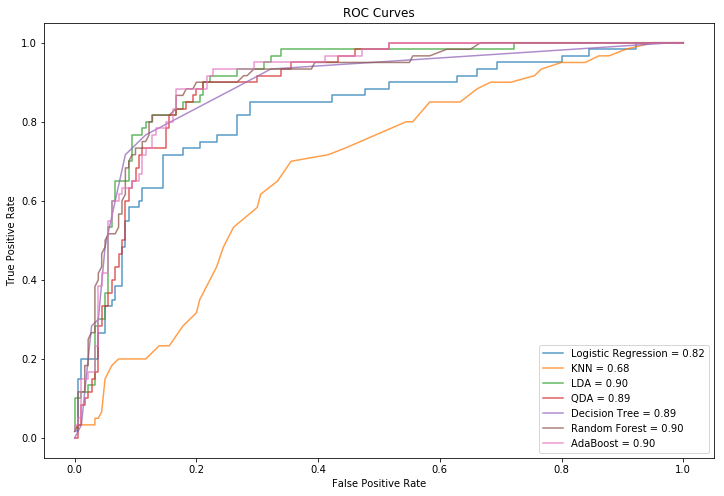

In [209]:
# Plot the ROC curve for all models
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig.suptitle("")
alpha = 0.75
ax.plot(fpr_log, tpr_log, alpha=alpha, label='Logistic Regression = %0.2f'% logregcv_roc_auc)
ax.plot(fpr_knn, tpr_knn, alpha=alpha, label='KNN = %0.2f'% knn_roc_auc)
ax.plot(fpr_lda, tpr_lda, alpha=alpha, label='LDA = %0.2f'% lda_roc_auc)
ax.plot(fpr_qda, tpr_qda, alpha=alpha, label='QDA = %0.2f'% qda_roc_auc)
ax.plot(fpr_dc, tpr_dc, alpha=alpha, label='Decision Tree = %0.2f'% dtc_roc_auc)
ax.plot(fpr_rf, tpr_rf, alpha=alpha, label='Random Forest = %0.2f'% rf_roc_auc)
ax.plot(fpr_ada, tpr_ada, alpha=alpha, label='AdaBoost = %0.2f'% ada_roc_auc)

ax.legend(loc='best');
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves');

The test set AUC performance of models such as Random Forest, LDA and ADABoost is ~90%.

This shows that using baseline values of predictors is highly predictive of the patient eventually getting AD.

From the EDA, the time to AD diagnosis of MCI/LMCI/CN subjects is from 5 to 120 months

Logistic Regression and KNN do not perform well compared to others

# Important Features

In [210]:
importance = rf.feature_importances_
p = pd.DataFrame(importance, index=X_train.columns.tolist(), columns=["Importance"])
p.sort_values('Importance',ascending=False)


,Importance
ADAS13_bl,0.180680
FAQ_bl,0.135573
Hippocampus_bl,0.106828
Entorhinal_bl,0.100272
MidTemp_bl,0.083358
Fusiform_bl,0.073336
RAVLT_perc_forgetting_bl,0.069808
AGE,0.065797
Ventricles_bl,0.064244
ICV_bl,0.062864


This shows that ADAS13 and FAQ scores that are taken at baseline are highly predictive of a subject getting AD in the future. Brain scans also turn out to be important predictors

ADAS - Alzheimer's Disease Assessment score

FAQ: Functional Activities Questionnaire